In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import math
import numpy

In [2]:
def gnp_random_graph(n, p, seed=None, directed=False):
    """Returns a $G_{n,p}$ random graph, also known as an Erdős-Rényi graph
    or a binomial graph.

    The $G_{n,p}$ model chooses each of the possible edges with probability $p$.

    Parameters
    ----------
    n : int
        The number of nodes.
    p : float
        Probability for edge creation.
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    directed : bool, optional (default=False)
        If True, this function returns a directed graph.

    See Also
    --------
    fast_gnp_random_graph

    Notes
    -----
    This algorithm [2]_ runs in $O(n^2)$ time.  For sparse graphs (that is, for
    small values of $p$), :func:`fast_gnp_random_graph` is a faster algorithm.

    :func:`binomial_graph` and :func:`erdos_renyi_graph` are
    aliases for :func:`gnp_random_graph`.

    >>> nx.binomial_graph is nx.gnp_random_graph
    True
    >>> nx.erdos_renyi_graph is nx.gnp_random_graph
    True

    References
    ----------
    .. [1] P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).
    .. [2] E. N. Gilbert, Random Graphs, Ann. Math. Stat., 30, 1141 (1959).
    """
    if directed:
        edges = itertools.permutations(range(n), 2)
        G = nx.DiGraph()
    else:
        edges = itertools.combinations(range(n), 2)
        G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return complete_graph(n, create_using=G)

    for e in edges:
        if seed.random() < p:
            G.add_edge(*e)
    return G

In [3]:
def averageInDegree(G):
    # sum of the degrees of all its nodes divided by the number of nodes in the graph
    degreeSum = 0
    for node in G.nodes: 
        degreeSum += (G.in_degree[node])
    
    # divide by number of nodes
    return degreeSum/len(G.nodes)
    
def UserActivity(G,node_num):
    return (G.in_degree[node_num]*random.random())/(len(G.nodes))

In [4]:
def sigmoid(x):
    return ((2)/(1+math.exp(-x)))-1


In [5]:
# Compute f_u for all nodes in G 
def compute_tweet_prob(G, TS, UA, scale_factor):
    scale_factor = scale_factor
    w_1 = 0.1
    w_2 = 1-w_1
    
    # compute f_u 
    f = (w_1*TS + w_2*UA)*scale_factor
        
    return f
    

In [6]:
def isMentioned(G,node1,node2):
    isMentioned = 0
    
    if node2 in list(G.neighbors(node1)) and node2 in list(G.predecessors(node1)):
        isMentioned = 1
        
    # add random factor 
    return isMentioned*random.random()

In [7]:
def compute_retweet_prob(G,node1,node2,scale_factor,TS,UA):
    #node1 tweeter/retweeter, node2 follower 
    scale_factor = scale_factor
    # Compute # common following
    # A successor of n is a node m such that there exists a directed edge from n to m. Same as neighbors()
    node1_following = set(G.neighbors(node1))
    node2_following = set(G.neighbors(node2))
    
    
    num_common_following = len(node1_following.intersection(node2_following))
    #print('# Common Following: ', num_common_following)
    # Compute # common followers
    # A predecessor of n is a node m such that there exists a directed edge from m to n.


    node1_followers = set(G.predecessors(node1))
    node2_followers = set(G.predecessors(node2))
    
    num_common_followers = len(node1_followers.intersection(node2_followers))
    #print('# Common Followers: ', num_common_followers)

    # Compute Similarity Score 
    w_following = 0.5
    w_followers = 1-w_following 
    
    SS = w_following*num_common_following + w_followers*num_common_followers
    
    # Compute IsMentioned
    IM = isMentioned(G,node1,node2)
    
    # Compute r_u 
    w_SS = 0.4
    w_TS = 0.1
    w_UA = 0.25
    w_IM = 0.25
    
    r_u = scale_factor*(w_SS*SS + w_TS*TS + w_UA*UA + w_IM*IM)
    
    return r_u

In [8]:
def total_degree_sum(p, num_nodes):
    return p*(num_nodes**2)

In [9]:
import numpy as np 
# Create degree distribution with higher standard deviation
def createRandomDist(num_nodes, average,totalDegSum):
    degrees = []
    out_degrees = []
    
    in_degrees = np.random.dirichlet(np.ones(numNodes-1),size=1)[0]
    out_degrees = np.random.dirichlet(np.ones(numNodes-1),size=1)[0]
    
    in_degrees_final = [int(d*totalDegSum) for d in in_degrees]
    out_degrees_final = [int(d*totalDegSum) for d in out_degrees]
    
    # create last value 
    in_deg_sum = sum(in_degrees_final)
    out_deg_sum = sum(out_degrees_final)
    
    diff = in_deg_sum - out_deg_sum 
    
    if diff<0:  # outdeg>indeg
        out_degrees_final.append(0)
        in_degrees_final.append((-1)*diff)
    elif diff>0: # indeg>outeg
        out_degrees_final.append(diff)
        in_degrees_final.append(0)
    else:
        rannum = random.randint(0,300)
        out_degrees_final.append(rannum)
        in_degrees_final.append(rannum)
    
    return in_degrees_final, out_degrees_final


In [10]:
def mff(G, f, r, f_0, r_0):
    S = set()
    N = set()
    fire = [] 
    
    num_spreaders = []
    num_nonspreaders = []
    num_trees = []
    iterations = 0
    status = {}
    checkpoint_frequency = 4
    num_checkpoints = len(G.nodes)/checkpoint_frequency
    
    # 4 checkpoints
    N_checkpoints = []
    
    S_checkpoints = [] 
    
    
    # Initialize statuses of nodes
    for node in G.nodes(): 
        if f[node] >= f_0: 
            print('Node caught on fire: ', node)
            status[node] = 1
            fire.append(node)
            S.add(node)
        else: 
            status[node] = 0
    
    # Status Guide
        # 1 : fire
        # 0 : tree
        # -1 : burnt

    # Update node statuses 
    while (len(fire)!=0):
        # print('# nodes still on fire: ', len(fire))
        node = fire.pop()
        
        # Check neighbros of node on fire
        for neighbor in G.predecessors(node):
            if status[neighbor] == 0 or status[neighbor] == -1: 
                if r[(node,neighbor)]>= r_0:
                    status[neighbor] = 1
                    fire.append(neighbor)
                    S.add(neighbor)
                    if neighbor in N: 
                        N.remove(neighbor)
                    # change something to fire --> change needToContinue = 1 
                else: 
                    status[neighbor] = -1
                    N.add(neighbor)
        
            num_spreaders.append(len(S))
            num_nonspreaders.append(len(N))
            num_trees.append(len(G.nodes)-(len(S)+len(N)))
            
            if (iterations%num_checkpoints==0):
                N_copy = N.copy()
                S_copy = S.copy()

                N_checkpoints.append(N_copy)
                S_checkpoints.append(S_copy)
                
            iterations= iterations + 1

                
        # query length of S, see if length changed in order to see if nay more nodes caught on fire     
        # line before while loop- needToContinue
        # while needToContinue:
        # needToContninue = 0 
        # could also just keep a nodesVisited, or list of newly fired nodes 
        # LOGIC: every time a node catches on fire, you need to check all of its neighbors later 

    
    return S,N, num_spreaders, num_nonspreaders, num_trees, iterations, N_checkpoints, S_checkpoints
                

# Run 1

In [11]:
# Graph 

numNodes = 5000
p = 0.15
averageDeg = numNodes*p
totalDegSum = total_degree_sum(p,numNodes)

degree = createRandomDist(numNodes, averageDeg,totalDegSum)
in_degrees = degree[0]
#print(type(in_degrees))
out_degrees = degree[1]
#print("\n IN DEGREES \n")
#print((in_degrees))
#print("\n OUT DEGREES \n")
#print((out_degrees))

In [12]:
#G1 = gnp_random_graph(n=1000, p=0.15, seed=numpy.random, directed=True)
G1 = nx.directed_configuration_model(in_degree_sequence = in_degrees,out_degree_sequence = out_degrees)

In [13]:
# Compute all user activities and topic significance 

UA = {}
for node in G1.nodes: 
    UA[node] = UserActivity(G1,node)
    
TS = 1

In [14]:
#### Compute tweet probs 
f_u = {}
f_u_sigmoid = {}
scale_factor = 1.5
for node in G1.nodes: 
    # compute f_u 
    f =  compute_tweet_prob(G1,TS,UA[node],scale_factor)
    f_u[node]=f
    f_u_sigmoid[node] = sigmoid(f)

print(sorted(f_u_sigmoid.values()))

[0.0748596906874992, 0.07486180713539148, 0.07486562752240022, 0.0748832794077694, 0.07489112103916251, 0.07489210547528069, 0.07489251726189106, 0.07489382916008203, 0.07489978744025083, 0.07490414107409982, 0.0749061692593973, 0.074909053202179, 0.07491160445918155, 0.07491324955460787, 0.07491514884010564, 0.07491837033807269, 0.0749212278452045, 0.07492287461613789, 0.0749233068698405, 0.07492553039871441, 0.07492586462211115, 0.07492860952791158, 0.0749313725432248, 0.07493498293397427, 0.07493730688188172, 0.07493834718155812, 0.07494655753737756, 0.07494755209718651, 0.07495122989537606, 0.07495482603568471, 0.07495908639388116, 0.07497078825618164, 0.07498044512382296, 0.0749827786895203, 0.0749874834373685, 0.07498863539893375, 0.0749901466116285, 0.07499062935232415, 0.07499081886338144, 0.07499169880515244, 0.07499482708745808, 0.07499594019850897, 0.07500019974908789, 0.0750059675888235, 0.07500700950084571, 0.0750119086778791, 0.07501220745511361, 0.07501788535209553, 0.07

In [15]:
#### Computing retweet prob
r_u = {}
r_u_sigmoid = {}
scale_factor = 0.0
for node in G1.nodes: 
    # loop through followers
    
    for follower in G1.predecessors(node):
        r = compute_retweet_prob(G1,node,follower,scale_factor,TS,UA[node])
        r_u[(node,follower)] = r
#         print("r, sigmoid r")
#         print(r)
        r_u_sigmoid[(node,follower)] = sigmoid(r)
#         print(sigmoid(r))
        # Might need to pass through a sigmoid function? 
        


In [16]:
# RUN 
r_0 = 0.5
f_0 = 0.5
lists = mff(G1,f_u_sigmoid,r_u_sigmoid,f_0,r_0)
S = lists[0]
N = lists[1]
num_S = lists[2]
num_N = lists[3]
num_T = lists[4]

N_checkpoints = lists[6]
S_checkpoints = lists[7]

iterations = lists[5]
# print('Spreaders: ',S)
# print('Non-Spreaders: ',N)

Node caught on fire:  601
Node caught on fire:  1648
Node caught on fire:  2017
Node caught on fire:  2059
Node caught on fire:  3407
Node caught on fire:  3533
Node caught on fire:  3574
Node caught on fire:  4799
Node caught on fire:  4861


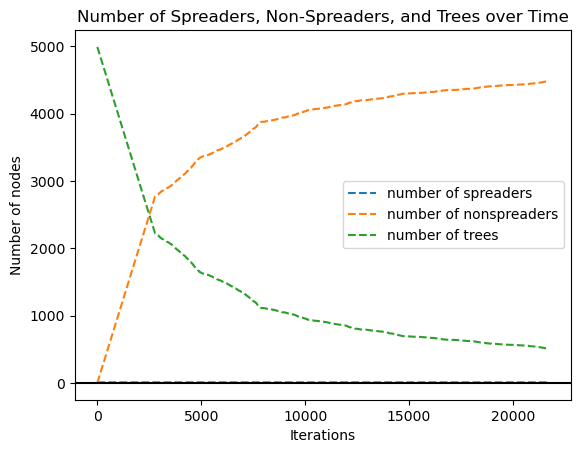

In [17]:
import matplotlib.pyplot as plt

plt.plot(num_S, label='number of spreaders',linestyle='dashed')
plt.plot(num_N, label='number of nonspreaders',linestyle='dashed')
plt.plot(num_T, label='number of trees',linestyle='dashed')
plt.axhline(y=0, color='black', linestyle='-')

plt.xlabel('Iterations')
plt.ylabel('Number of nodes')
plt.title('Number of Spreaders, Non-Spreaders, and Trees over Time')
plt.legend()
plt.show()

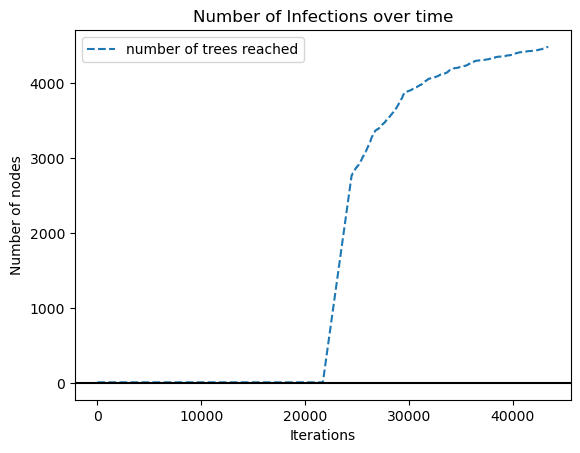

In [18]:
num_infected = num_S + num_N
plt.plot(num_infected, label='number of trees reached',linestyle='dashed')
plt.axhline(y=0, color='black', linestyle='-')

plt.xlabel('Iterations')
plt.ylabel('Number of nodes')
plt.title('Number of Infections over time')
plt.legend()
plt.show()